In [114]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import pymysql
import config

In [115]:
rds_host  = config.db_endpoint
name = config.db_username
password = config.db_password
db_name = config.db_name
port = 3306
conn = pymysql.connect(rds_host, user=name,
                           passwd=password, db=db_name, connect_timeout=5)

In [142]:
cur = conn.cursor()
tweets_complete = [2,3,4,5]
tweet_nums = []
cur.execute("SELECT id FROM NewTweets")
result_set = cur.fetchall()
for row in result_set:
    tweet_nums.append(int(row[0]))


tweets_to_process = [x for x in tweet_nums if x not in tweets_complete]
print(tweets_to_process)



row = cur.execute("SELECT * FROM NewTweets WHERE id="+str(tweets_to_process[0])+";")
row = cur.fetchone()
print(row)
tweet_num = row[4]
timestamp = row[0]
image_url = row[1]
style_url = row[2]
username = row[3]


[6]
('Wed Jun 20 00:40:21 +0000 2018', 'http://pbs.twimg.com/media/DgGFUicVQAE-YLo.jpg', 'http://pbs.twimg.com/media/DgGFUidVMAAnBxG.jpg', 'trvl_agnt', '6')


In [119]:
import requests

img_data = requests.get(image_url).content
with open('image.jpg', 'wb') as handler:
    handler.write(img_data)


style_data = requests.get(style_url).content
with open('style.jpg', 'wb') as handler:
    handler.write(style_data)

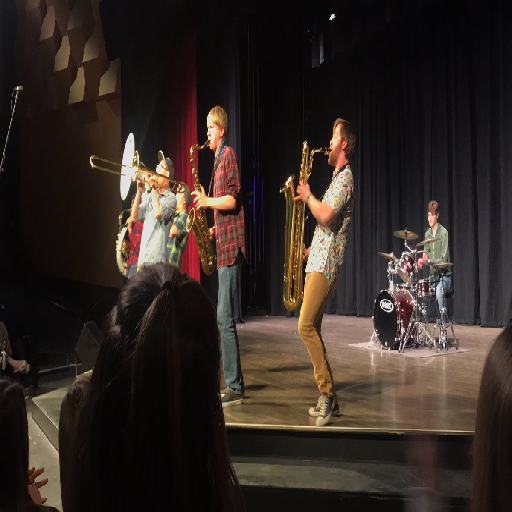

In [120]:
height = 512
width = 512
content_image = Image.open('image.jpg')
content_image = content_image.resize((height, width))
content_image

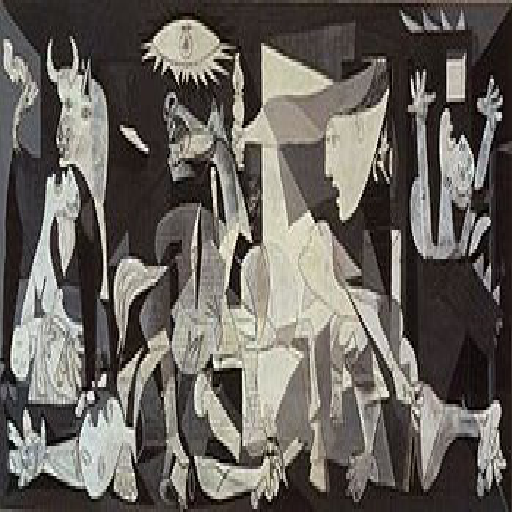

In [121]:
style_image_path = 'style.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

In [122]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [123]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [124]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [125]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [126]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [127]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 64, 64, 51

In [128]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [129]:
loss = backend.variable(0.)

In [130]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [131]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [132]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [133]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [134]:
grads = backend.gradients(loss, combination_image)

In [135]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [145]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 8.63281e+10
Iteration 0 completed in 8s
Start of iteration 1
Current loss value: 4.88806e+10
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 3.69048e+10
Iteration 2 completed in 9s
Start of iteration 3
Current loss value: 3.15201e+10
Iteration 3 completed in 8s
Start of iteration 4
Current loss value: 2.82992e+10
Iteration 4 completed in 8s
Start of iteration 5
Current loss value: 2.66047e+10
Iteration 5 completed in 9s
Start of iteration 6
Current loss value: 2.54804e+10
Iteration 6 completed in 9s
Start of iteration 7
Current loss value: 2.45488e+10
Iteration 7 completed in 8s
Start of iteration 8
Current loss value: 2.39695e+10
Iteration 8 completed in 9s
Start of iteration 9
Current loss value: 2.35677e+10
Iteration 9 completed in 9s


In [146]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

result = Image.fromarray(x)
result.save('temp.jpg')

In [147]:
tweets_complete.append(int(tweet_num))
print(tweets_complete)

[2, 3, 4, 5, 6, 6]


In [148]:
from twitter import Api
api = Api(config.consumer_key,
          config.consumer_secret,
          config.access_token_key,
          config.access_token_secret)

In [152]:
api.PostUpdate(media = "temp.jpg", status = "Hope you like it, @"+username)

Status(ID=1009238296583602176, ScreenName=mlstylephoto, Created=Wed Jun 20 00:55:35 +0000 2018, Text=u'Hope you like it, @trvl_agnt https://t.co/RixqFSnkYU')